In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
from langchain.llms import OpenAI

In [3]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [4]:
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0.9)

In [5]:
text = "Suggest a personalized workout routine for someone looking to improve cardiovascular endurance and prefers outdoor activities."
print(llm(text))



Monday:
- Jogging for 30 minutes at a moderate pace 
- 10 minutes of high-intensity interval training (HIIT) such as sprinting for 30 seconds, followed by 1 minute of walking 
- 3 sets of 10 push-ups 
- 3 sets of 10 squats 

Tuesday:
- Cycling for 45 minutes at a steady pace 
- 3 sets of 10 lunges 
- 3 sets of 10 tricep dips on a bench or step 
- 10 minutes of stretching and foam rolling 

Wednesday:
- Hiking for 60 minutes on a moderate-difficult trail 
- 3 sets of 10 mountain climbers 
- 3 sets of 10 burpees 
- 3 sets of 10 Russian twists 

Thursday:
- Swimming for 45 minutes at a steady pace 
- 3 sets of 10 step-ups on a bench or step 
- 3 sets of 10 bicep curls with dumbbells 
- 10 minutes of yoga or Pilates for stretching and core strengthening 

Friday:
- High-intensity interval training (HIIT) using bodyweight exercises such as jumping jacks, high knees, and plank jacks for 30 seconds,


# The Chains

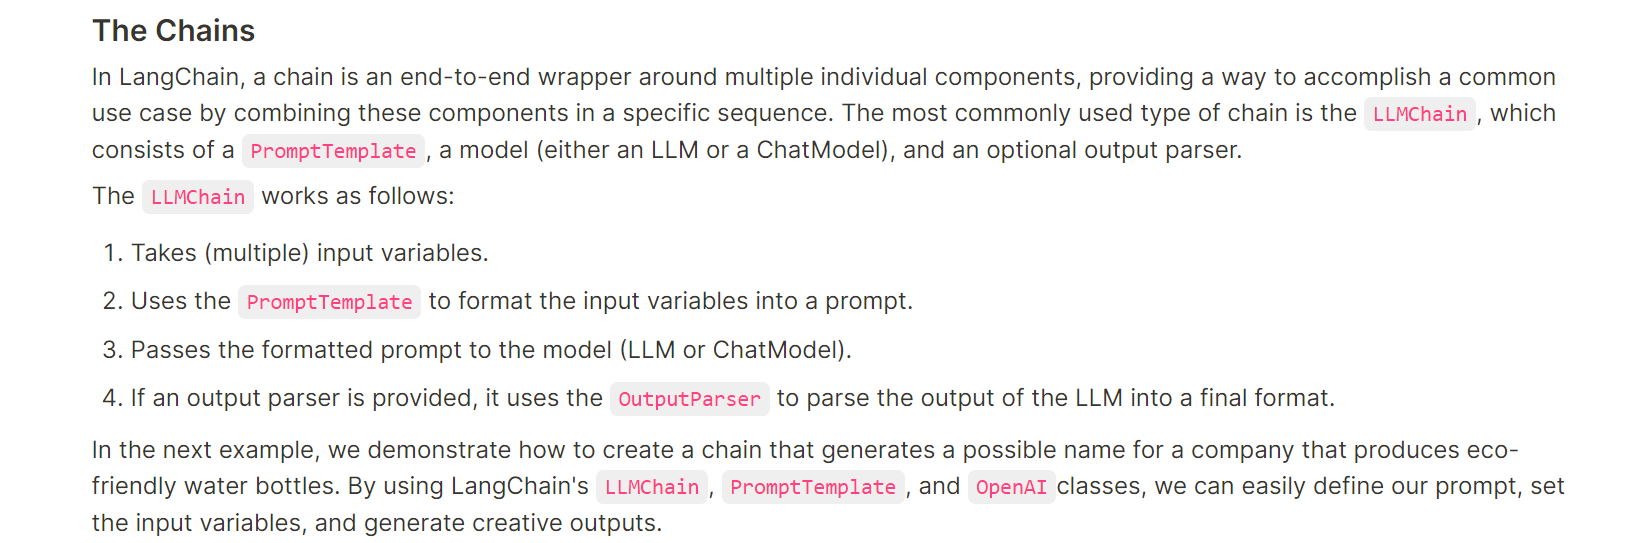

In [6]:
from langchain.chains import LLMChain
from langchain.llms import OpenAI
from langchain.prompts import PromptTemplate

llm  = OpenAI(model = 'gpt-3.5-turbo-instruct', temperature = 0.9)

prompt = PromptTemplate(
    input_variables = ['product'],
    template = 'What is a good name for a company that makes {product}?'
)

chain = LLMChain(llm = llm, prompt = prompt)

print(chain.run('eco friendly water bottles'))



"GreenWater Co." 


# The Memory

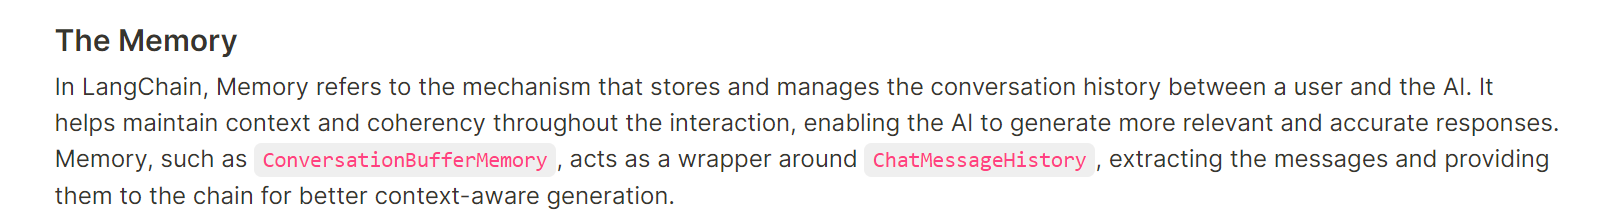

In [7]:
from langchain.llms import OpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)

conversation = ConversationChain(
    llm=llm,
    verbose=True,
    memory=ConversationBufferMemory()
)

# Start the conversation
conversation.predict(input="Tell me about yourself.")

# Continue the conversation
conversation.predict(input="What can you do?")
conversation.predict(input="How can you help me with data analysis?")

# Display the conversation
print(conversation)



> Entering new  chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Tell me about yourself.
AI:

> Finished chain.


> Entering new  chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Tell me about yourself.
AI:  Well, I am an artificial intelligence created by a team of programmers and engineers. My purpose is to assist and interact with humans in various tasks and conversations. I am constantly learning and improving through algorithms and data analysis. I am currently housed in a server room with other

# Datalake

In [8]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import DeepLake
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA


# instantiate the LLM and embeddings models
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

# create our documents
texts = [
    "Napoleon Bonaparte was born in 15 August 1769",
    "Louis XIV was born in 5 September 1638"
]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.create_documents(texts)

# create Deep Lake dataset
# TODO: use your organization id here. (by default, org id is your username)
my_activeloop_org_id = "vaibhavvtrip" 
my_activeloop_dataset_name = "langchain_course_from_zero_to_hero"
dataset_path = f"hub://{my_activeloop_org_id}/{my_activeloop_dataset_name}"
db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)

# add documents to our Deep Lake dataset
db.add_documents(docs)

Your Deep Lake dataset has been successfully created!


Creating 2 embeddings in 1 batches of size 2:: 100%|█████████████████████████████████████| 1/1 [00:18<00:00, 18.54s/it]

Dataset(path='hub://vaibhavvtrip/langchain_course_from_zero_to_hero', tensors=['text', 'metadata', 'embedding', 'id'])

  tensor      htype      shape     dtype  compression
  -------    -------    -------   -------  ------- 
   text       text      (2, 1)      str     None   
 metadata     json      (2, 1)      str     None   
 embedding  embedding  (2, 1536)  float32   None   
    id        text      (2, 1)      str     None   


['0020970d-063f-11ef-8ebc-489ebd4da941',
 '0020970e-063f-11ef-8b91-489ebd4da941']

Now, let's create a RetrievalQA chain:

In [9]:
retrieval_qa = RetrievalQA.from_chain_type(
	llm=llm,
	chain_type="stuff",
	retriever=db.as_retriever()
)

Next, let's create an agent that uses the RetrievalQA chain as a tool:

In [10]:
from langchain.agents import initialize_agent, Tool
from langchain.agents import AgentType

tools = [
    Tool(
        name="Retrieval QA System",
        func=retrieval_qa.run,
        description="Useful for answering questions."
    ),
]

agent = initialize_agent(
	tools,
	llm,
	agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
	verbose=True
)

Finally, we can use the agent to ask a question:

In [11]:
response = agent.run("When was Napoleone born?")
print(response)



> Entering new  chain...
 I should use the Retrieval QA System to answer this question
Action: Retrieval QA System
Action Input: When was Napoleone born?
Observation: 
Napoleon Bonaparte was born in 15 August 1769.
Thought: I now know the final answer
Final Answer: Napoleon Bonaparte was born in 15 August 1769.

> Finished chain.
Napoleon Bonaparte was born in 15 August 1769.


Here, the agent used the “Retrieval QA System” tool with the query “When was Napoleone born?” which is then run on our new Deep Lake dataset, returning the most similar document (i.e., the document containing the date of birth of Napoleon). This document is eventually used to generate the final output.

Let’s add an example of reloading an existing vector store and adding more data.

We first reload an existing vector store from Deep Lake that's located at a specified dataset path. Then, we load new textual data and split it into manageable chunks. Finally, we add these chunks to the existing dataset, creating and storing corresponding embeddings for each added text segment:

In [12]:
# load the existing Deep Lake dataset and specify the embedding function
db = DeepLake(dataset_path=dataset_path, embedding_function=embeddings)

# create new documents
texts = [
    "Lady Gaga was born in 28 March 1986",
    "Michael Jeffrey Jordan was born in 17 February 1963"
]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.create_documents(texts)

# add documents to our Deep Lake dataset
db.add_documents(docs)

Deep Lake Dataset in hub://vaibhavvtrip/langchain_course_from_zero_to_hero already exists, loading from the storage


Creating 2 embeddings in 1 batches of size 2:: 100%|█████████████████████████████████████| 1/1 [00:20<00:00, 20.67s/it]

Dataset(path='hub://vaibhavvtrip/langchain_course_from_zero_to_hero', tensors=['embedding', 'id', 'metadata', 'text'])

  tensor      htype      shape     dtype  compression
  -------    -------    -------   -------  ------- 
 embedding  embedding  (4, 1536)  float32   None   
    id        text      (4, 1)      str     None   
 metadata     json      (4, 1)      str     None   
   text       text      (4, 1)      str     None   


['1d1cba44-063f-11ef-81c3-489ebd4da941',
 '1d1cba45-063f-11ef-aad7-489ebd4da941']

In [13]:
response = agent.run("When was Michael Jordan born?")
print(response)

#the output would give error result(when halted during iteration) because agent is not updated



> Entering new  chain...
 I should use the Retrieval QA System to find the answer.
Action: Retrieval QA System
Action Input: "When was Michael Jordan born?"
Observation:  I don't know.
Thought: I should try rephrasing the question.
Action: Retrieval QA System
Action Input: "What is Michael Jordan's birthdate?"
Observation:  I don't know.
Thought: I should try using a different source.
Action: Retrieval QA System
Action Input: "When was Michael Jordan born?"
Observation:  I don't know.
Thought: I should try using a different source.
Action: Retrieval QA System
Action Input: "When was Michael Jordan born?"
Observation:  I don't know.
Thought: I should try using a different source.
Action: Retrieval QA System
Action Input: "When was Michael Jordan born?"
Observation:  I don't know.
Thought: I should try using a different source.
Action: Retrieval QA System
Action Input: "When was Michael Jordan born?"
Observation:  I don't know.
Thought: I should try using a different source.
Action: Re

We need to recreate our previous agent and ask a question that can be answered only by the last documents added.

In [14]:
# instantiate the wrapper class for GPT3
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)

# create a retriever from the db
retrieval_qa = RetrievalQA.from_chain_type(
	llm=llm, chain_type="stuff", retriever=db.as_retriever()
)

# instantiate a tool that uses the retriever
tools = [
    Tool(
        name="Retrieval QA System",
        func=retrieval_qa.run,
        description="Useful for answering questions."
    ),
]

# create an agent that uses the tool
agent = initialize_agent(
	tools,
	llm,
	agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
	verbose=True
)

In [15]:
response = agent.run("When was Michael Jordan born?")
print(response)



> Entering new  chain...
 I should use the Retrieval QA System to find the answer.
Action: Retrieval QA System
Action Input: "When was Michael Jordan born?"
Observation:  Michael Jordan was born on 17 February 1963.
Thought: I now know the final answer.
Final Answer: Michael Jordan was born on 17 February 1963.

> Finished chain.
Michael Jordan was born on 17 February 1963.


# Agents in Langchain

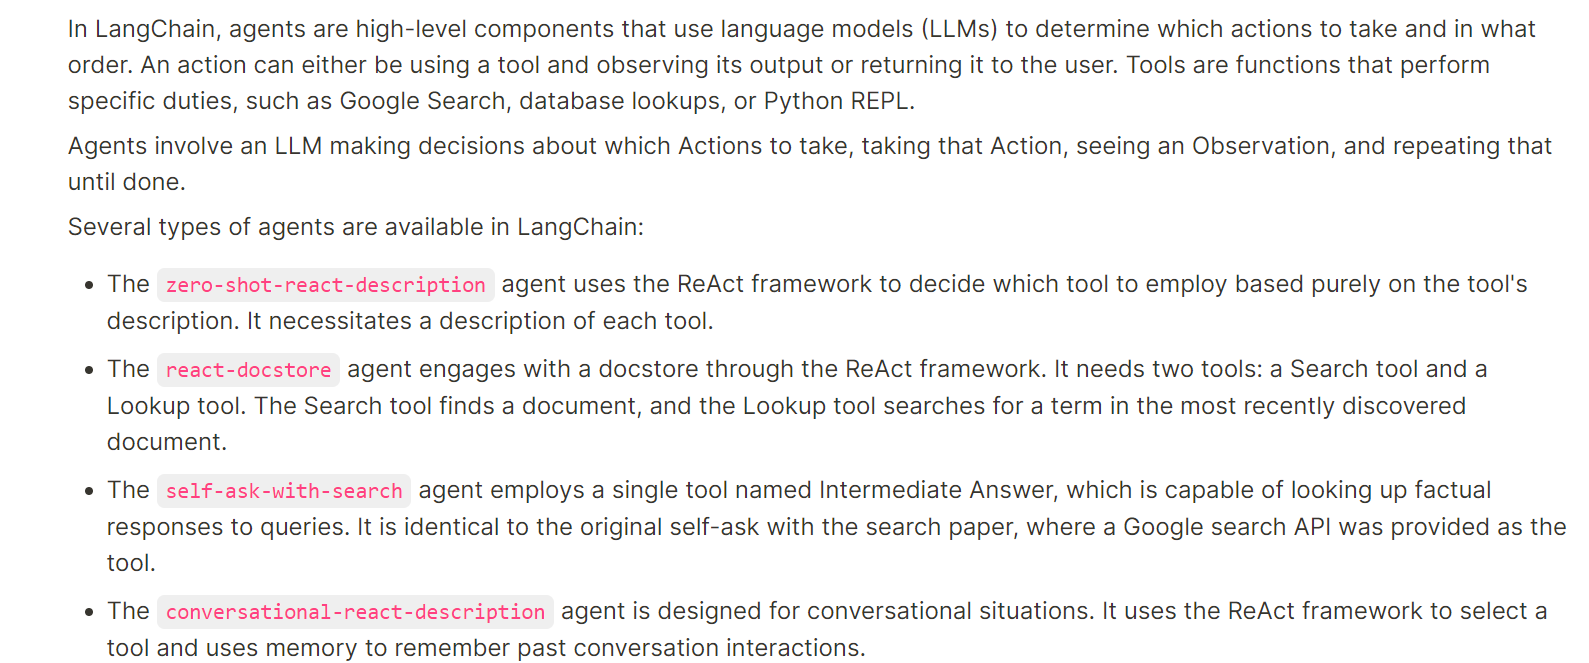

In [16]:
# In our example, the Agent will use the Google Search tool to look up recent information 
# about the Mars rover and generates a response based on this information.

# First, you want to set the environment variables “GOOGLE_API_KEY” and “GOOGLE_CSE_ID” 
# to be able to use Google Search via API. 

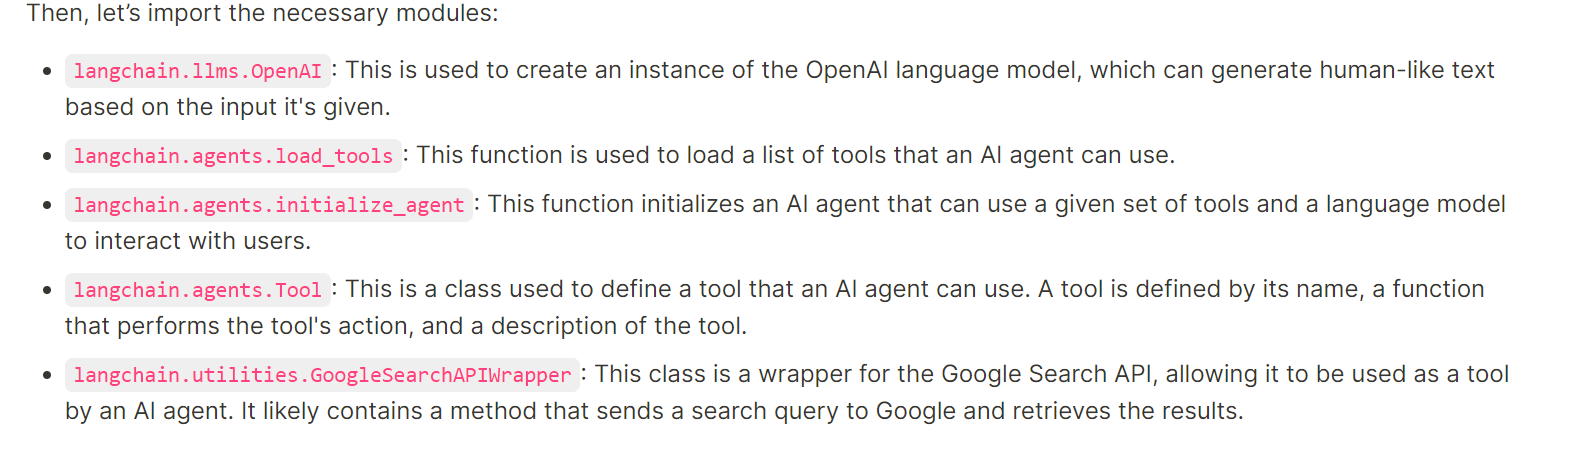

In [17]:
from langchain.llms import OpenAI

from langchain.agents import AgentType
from langchain.agents import load_tools
from langchain.agents import initialize_agent

from langchain.agents import Tool
from langchain.utilities import GoogleSearchAPIWrapper

In [18]:
# We’ll initialize the LLM and set the temperature to 0 for the precise answer. 
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)

In [19]:
# remember to set the environment variables
# “GOOGLE_API_KEY” and “GOOGLE_CSE_ID” to be able to use
# Google Search via API.
search = GoogleSearchAPIWrapper()

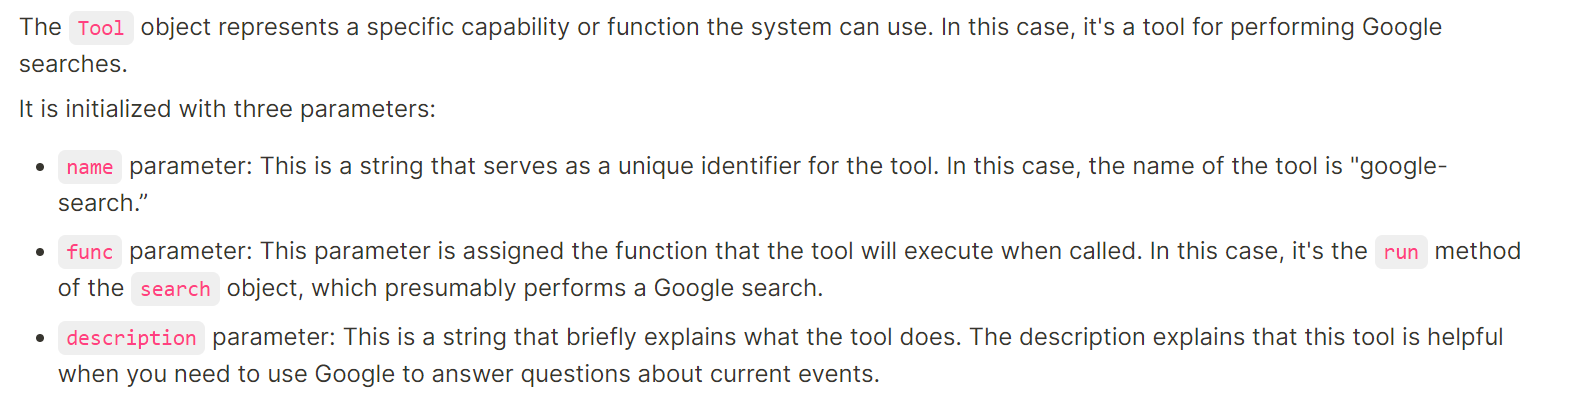

In [20]:
tools = [
    Tool(
        name = "google-search",
        func=search.run,
        description="useful for when you need to search google to answer questions about current events"
    )
]

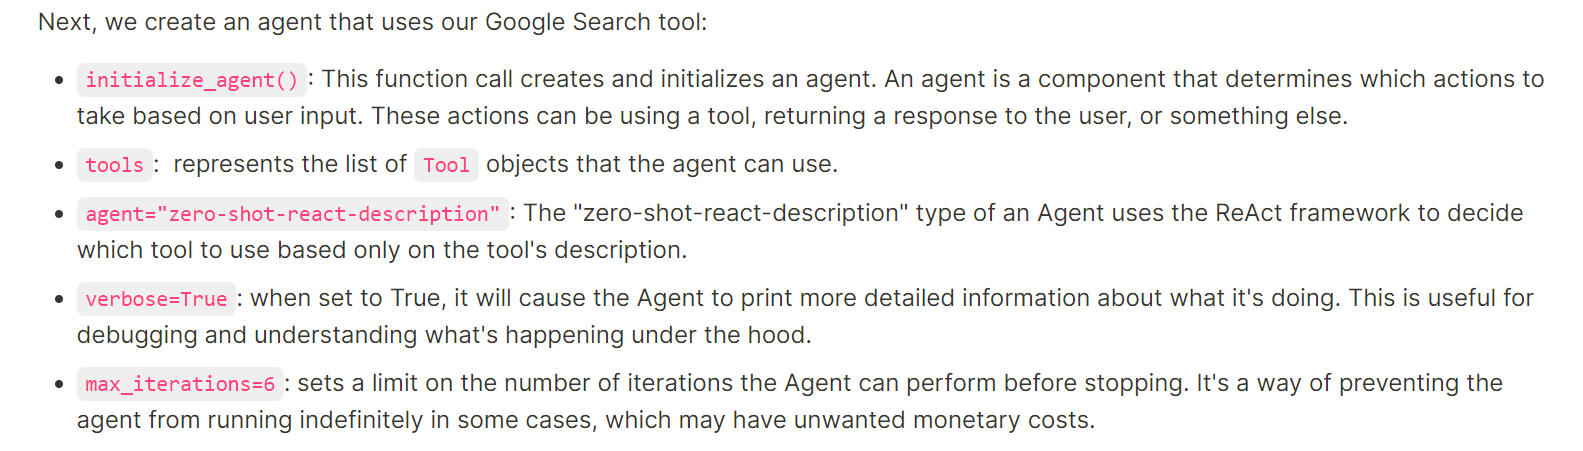

In [21]:
agent = initialize_agent(tools, 
                         llm, 
                         agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, 
                         verbose=True,
                         max_iterations=6)

In [22]:
response = agent("What's the latest news about the Mars rover?")
print(response['output'])



> Entering new  chain...
 I should search for news articles about the Mars rover.
Action: google-search
Action Input: "Mars rover news"
Observation: Why is Methane Seeping on Mars? NASA Scientists Have New Ideas ... The most surprising revelation from NASA's Curiosity Mars Rover — that methane is seeping from ... Mar 19, 2024 ... Is the Mars rover's rock collection worth $11 billion? ... An image from NASA's Mars Perseverance rover ... News 25 APR 24. The rover has arrived at an area that may show evidence liquid water flowed on this part of Mars for much longer than previously thought. NASA's Curiosity rover ... Apr 25, 2023 ... The fully robotic Zhurong, named after a mythical Chinese god of fire, was expected to have woken up in December after entering a planned sleep ... Oct 19, 2022 ... ... Curiosity, visit: http://mars.nasa.gov/msl. Get the Latest JPL News. SUBSCRIBE TO THE NEWSLETTER. News Media Contact. Andrew Good. Jet ... Curiosity Rover · Nasa's Mars rover finds mysterious

#  Tools in Langchain

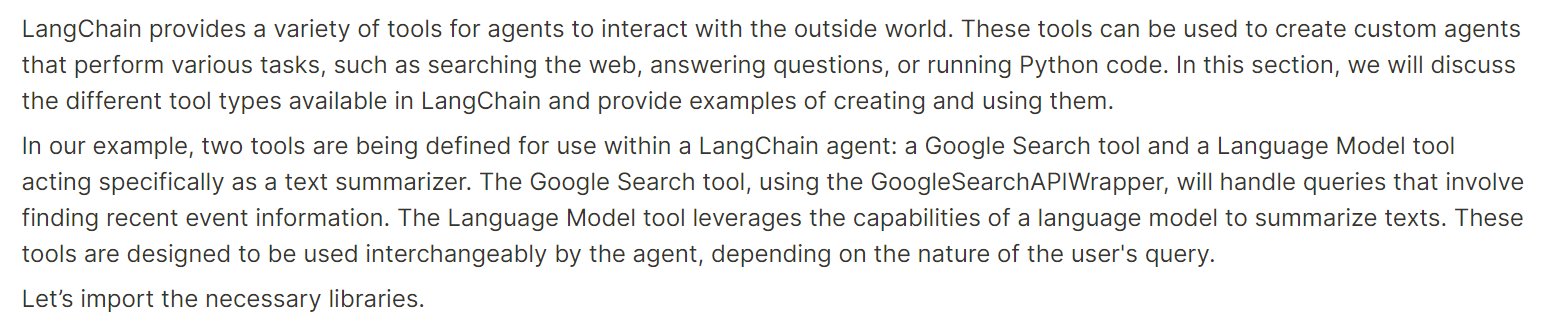

In [23]:
from langchain.llms import OpenAI
from langchain.agents import Tool
from langchain.utilities import GoogleSearchAPIWrapper
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.agents import initialize_agent, AgentType

In [24]:
# We then instantiate a  LLMChain specifically for text summarization.
llm = OpenAI(model="gpt-3.5-turbo-instruct", temperature=0)

prompt = PromptTemplate(
    input_variables=["query"],
    template="Write a summary of the following text: {query}"
)

summarize_chain = LLMChain(llm=llm, prompt=prompt)

In [25]:
# Next, we create the tools that our agent will use.
search = GoogleSearchAPIWrapper()

tools = [
    Tool(
        name="Search",
        func=search.run,
        description="useful for finding information about recent events"
    ),
    Tool(
       name='Summarizer',
       func=summarize_chain.run,
       description='useful for summarizing texts'
    )
]

In [26]:
# We are now ready to create our agent that leverages two tools.
agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True  
)

In [28]:
response = agent("What's the latest news about the Mars rover? then please summarize the results.")
print(response['output'])



> Entering new  chain...
 I should use the Search tool to find recent news about the Mars rover.
Action: Search
Action Input: "Mars rover news"
Observation: Why is Methane Seeping on Mars? NASA Scientists Have New Ideas ... The most surprising revelation from NASA's Curiosity Mars Rover — that methane is seeping from ... Mar 19, 2024 ... Is the Mars rover's rock collection worth $11 billion? ... An image from NASA's Mars Perseverance rover ... News 25 APR 24. The rover has arrived at an area that may show evidence liquid water flowed on this part of Mars for much longer than previously thought. NASA's Curiosity rover ... Apr 25, 2023 ... The fully robotic Zhurong, named after a mythical Chinese god of fire, was expected to have woken up in December after entering a planned sleep ... Oct 19, 2022 ... ... Curiosity, visit: http://mars.nasa.gov/msl. Get the Latest JPL News. SUBSCRIBE TO THE NEWSLETTER. News Media Contact. Andrew Good. Jet ... Curiosity Rover · Nasa's Mars rover finds my

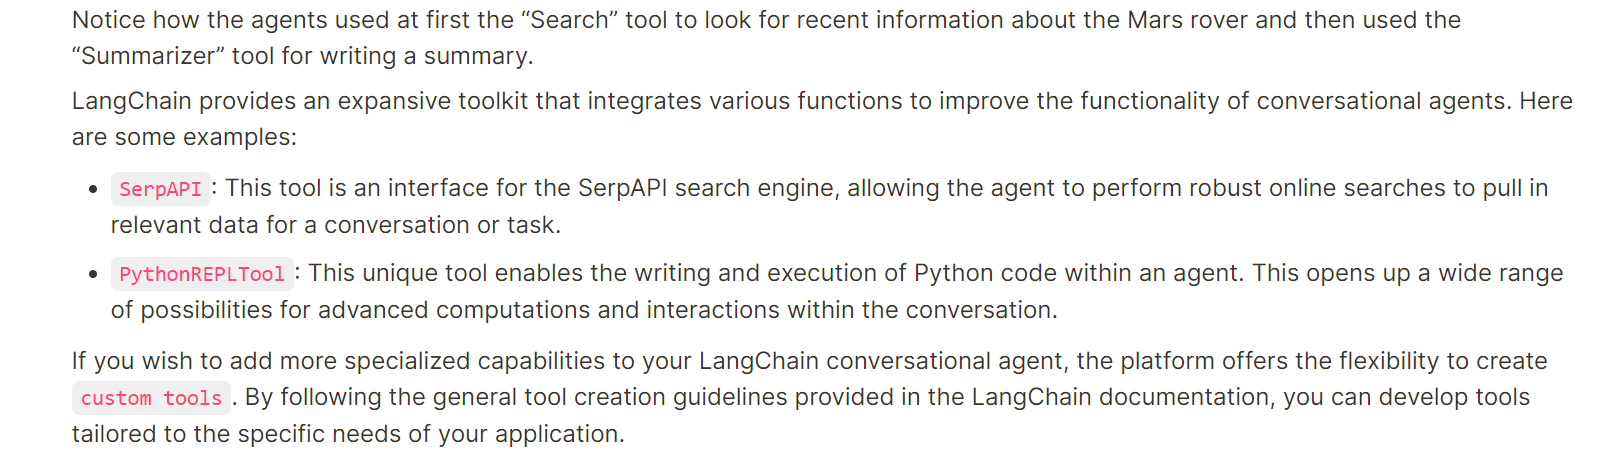